# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [41]:
# 📌 Step 1: Initialize the Liquidity Pools with Separate Reserves for X and Y
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Initial reserves for token pairs (A, X) and (A, Y)
R_A_X = 500  # Reserve of A for X pool
R_A_Y = 500  # Reserve of A for Y pool
R_X = 500     # Reserve of X
R_Y = 500     # Reserve of Y

# Constant product invariants for Uniswap V2
k_X = R_A_X * R_X  # Invariant for (A, X) pool
k_Y = R_A_Y * R_Y  # Invariant for (A, Y) pool

# Initial Prices
p_X = R_A_X / R_X  # Price of X in terms of A
p_Y = R_A_Y / R_Y  # Price of Y in terms of A

print(f"Initial Prices: p_X = {p_X:.4f}, p_Y = {p_Y:.4f}")
print(f"Initial Invariants: k_X = {k_X}, k_Y = {k_Y}")

Initial Prices: p_X = 1.0000, p_Y = 1.0000
Initial Invariants: k_X = 250000, k_Y = 250000


In [33]:
# 📌 Step 2: Define Swap Functions for A -> X and A -> Y with Separate Reserves

def swap_A_for_X(delta_A, R_A_X, R_X, k_X, fee_multiplier = 0.99):
    """
    Swap function: Exchanging A for X using Uniswap V2 formula with separate A reserves.
    """
    delta_A_effective = delta_A * fee_multiplier
    new_R_X = k_X / (R_A_X + delta_A_effective)
    delta_X = R_X - new_R_X
    return delta_X, new_R_X

def swap_A_for_Y(delta_A, R_A_Y, R_Y, k_Y, fee_multiplier = 0.99):
    """
    Swap function: Exchanging A for Y using Uniswap V2 formula with separate A reserves.
    """
    delta_A_effective = delta_A * fee_multiplier  # Apply the fee
    new_R_Y = k_Y / (R_A_Y + delta_A_effective)  # Solve for new R_Y
    delta_Y = R_Y - new_R_Y  # Amount of Y received
    return delta_Y, new_R_Y


In [4]:
# 📌 Step 3: Arbitrage Condition Check

def arbitrage_check(p_X, p_Y):
    """
    Checks if arbitrage is possible:
    - If p_X + p_Y > 1, merge X & Y into A.
    - If p_X + p_Y < 1, split A into X & Y.
    - Otherwise, equilibrium is maintained.
    """
    if p_X + p_Y > 1:
        return "Merge X & Y into A"
    elif p_X + p_Y < 1:
        return "Split A into X & Y"
    else:
        return "Equilibrium"


In [48]:
def update_prices():
    """
    Update prices of X and Y after swaps.
    """
    new_p_X = R_A_X / R_X  # Updated price of X
    new_p_Y = R_A_Y / R_Y  # Updated price of Y

    return new_p_X, new_p_Y

#     def swap_A_for_Y(self, delta_A, fee_multiplier=0.99):
#         """
#         Swap 'delta_A' of external A for Y in the (A, Y) pool.
#         """
#         delta_A_effective = delta_A * fee_multiplier
#         new_R_Y = self.k_Y / (self.R_A_Y + delta_A_effective)
#         delta_Y = self.R_Y - new_R_Y
#
#         self.R_A_Y += delta_A
#         self.R_Y = new_R_Y
#
#         print(f"User received {delta_Y:.4f} Y. And platform received {delta_Y:.4f} X.")
#         print(f"Platform paid {delta_Y - delta_A:.4f} A.")
#         self.external_X += delta_Y
#         self.external_A -= delta_Y - delta_A
#
#         self.p_Y = self.R_A_Y / self.R_Y
#
#         print(f"[swap_A_for_Y] Swapped {delta_A:.4f} A for {delta_Y:.4f} Y (fee {1-fee_multiplier:.2%}).")
#         self.log_state()
#         # self.arbitrage_action()
#         return delta_Y
#
#     def swap_X_for_A(self, delta_X, fee_multiplier=0.99):
#         """
#         Swap 'delta_X' of external X for A in the (A, X) pool.
#         """
#         if delta_X > self.external_X:
#             raise ValueError("Not enough X in external wallet to swap.")
#
#         delta_X_effective = delta_X * fee_multiplier
#         new_R_A_X = self.k_X / (self.R_X + delta_X_effective)
#         delta_A = self.R_A_X - new_R_A_X
#
#         self.R_X += delta_X
#         self.R_A_X = new_R_A_X
#
#         self.external_X -= delta_X
#         self.external_A += delta_A
#
#         self.p_X = self.R_A_X / self.R_X
#
#         print(f"[swap_X_for_A] Swapped {delta_X:.4f} X for {delta_A:.4f} A (fee {1-fee_multiplier:.2%}).")
#         self.log_state()
#         self.arbitrage_action()
#         return delta_A
#
#
#     def arbitrage_action(self):
#         """
#         After each swap, automatically check if p_X + p_Y > 1 (merge) or < 1 (split).
#         If so, perform a small 'merge' or 'split' using some external assets to capture arbitrage.
#         """
#         total_price = self.p_X + self.p_Y
#
#         if total_price > 1.000001:
#             print("[arbitrage_action] p_X + p_Y > 1 => Attempt MERGE (sell external X,Y for A).")
#             self.do_merge()
#         elif total_price < 0.999999:
#             print("[arbitrage_action] p_X + p_Y < 1 => Attempt SPLIT (buy X,Y with external A).")
#             self.do_split()
#         else:
#             print("[arbitrage_action] No significant arbitrage. (p_X + p_Y ~ 1)")
#
#     def do_merge(self, fee_multiplier=0.99):
#         """
#         Merge: Sell any external X and Y we hold for A.
#         This should push p_X + p_Y downward, closer to 1.
#         """
#         if self.external_X <= 0 and self.external_Y <= 0:
#             print("  Nothing to merge; no external X or Y.")
#             return
#
#         if self.external_X > 0:
#             self.swap_X_for_A(self.external_X, fee_multiplier=fee_multiplier)
#
#         if self.external_Y > 0:
#             self.swap_Y_for_A(self.external_Y, fee_multiplier=fee_multiplier)
#
#     def do_split(self, fee_multiplier=0.99):
#         """
#         Split: Use some of our external A to buy X and Y.
#         This should push p_X + p_Y upward, closer to 1.
#
#         For demonstration, we do a partial split (say 25% of our external A).
#         """
#         if self.external_A <= 0:
#             print("Nothing to split; no external A.")
#             return
#
#         amount_to_split = self.external_A * 0.25
#         half_split = amount_to_split / 2
#
#         self.swap_A_for_X(half_split, fee_multiplier=fee_multiplier)
#         self.swap_A_for_Y(half_split, fee_multiplier=fee_multiplier)
#

In [74]:
def compute_k_piecewise(x, y):
    if x <= 0 or y <= 0:
        raise ValueError("Both x and y must be positive.")
    if x <= y:
        return 1 - x / (2 * y)
    else:
        return y / (2 * x)

# Examples
print(compute_k_piecewise(500, 10000))


0.975


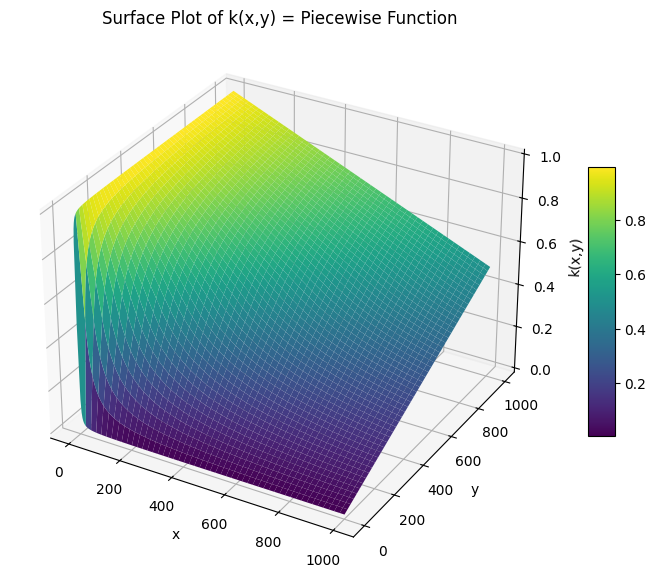

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting

def compute_k_piecewise(x, y):
    if x <= 0 or y <= 0:
        raise ValueError("Both x and y must be positive.")
    if x <= y:
        return 1 - x / (2 * y)
    else:
        return y / (2 * x)

# Create a grid of x and y values.
# Here we use a range from 1 to 1000 (you can adjust the range as needed).
x_vals = np.linspace(1, 1000, 400)
y_vals = np.linspace(1, 1000, 400)
X, Y = np.meshgrid(x_vals, y_vals)

# Vectorize the compute_k_piecewise function so it can be applied element-wise.
vectorized_compute_k = np.vectorize(compute_k_piecewise)
Z = vectorized_compute_k(X, Y)

# Plotting the surface
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surface = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')

# Add labels and a color bar
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('k(x,y)')
ax.set_title('Surface Plot of k(x,y) = Piecewise Function')
fig.colorbar(surface, shrink=0.5, aspect=10)

plt.show()

# Idea

## Question 1

Q: The user came to us with X amount of A. Depending on which price do we need to calculate his reward?

A:
Option 1: The outcome of curve where initial price is set to the 0.5 between X/Y and A



In [75]:
def compute_k_piecewise(x, y):
    if x <= 0 or y <= 0:
        raise ValueError("Both x and y must be positive.")
    if x <= y:
        return 1 - x / (2 * y)
    else:
        return y / (2 * x)

class UniswapV2:
    def __init__(self, initial_balance):
        """
        Initialize the model with a single parameter: total initial A balance.
        """

        arbitrage_balance = int(initial_balance * 0.2)
        invest_balance = initial_balance - arbitrage_balance

        balance_for_split = int(invest_balance * 0.5)
        balance_for_reserve = invest_balance - balance_for_split

        self.R_X, self.R_Y = balance_for_split, balance_for_split

        self.R_A_X = balance_for_reserve // 2
        self.R_A_Y = balance_for_reserve // 2

        self.external_A = arbitrage_balance
        self.external_X = 0
        self.external_Y = 0

        self.p_X = self.R_A_X / self.R_X
        self.p_Y = self.R_A_Y / self.R_Y

        print("=== Initialized UniswapV2 Pools ===")
        self.log_state()
        print("====================================\n")

    def buy_X(self, amount, fee_multiplier=1.2):
        """
        Buy 'amount' of X using external A.
        """
        k = compute_k_piecewise(self.R_X, self.R_Y)

        actual_out_A = amount * self.p_X

        print(f"actual_out_A: {actual_out_A}")

        self.R_A_Y -= actual_out_A
        self.R_Y += actual_out_A + amount
        self.p_Y = self.R_A_Y / self.R_Y

        new_R_X = self.R_A_X / (1 - self.p_Y)
        self.external_X += self.R_X - new_R_X
        self.R_X = new_R_X
        self.p_X = self.R_A_X / self.R_X

        print(f"User received {actual_out_A + amount} X.")

        self.reinvest()
        self.log_state()

        return actual_out_A + amount

    def buy_Y(self, amount, fee_multiplier=0.99):
        """
        Buy 'amount' of Y using external A.
        """
        actual_out_A = amount * self.p_X

        self.R_A_X -= actual_out_A
        self.R_X += actual_out_A + amount
        self.p_X = self.R_A_X / self.R_X

        new_R_Y = self.R_A_Y / (1 - self.p_X)
        self.external_Y += self.R_Y - new_R_Y
        self.R_Y = new_R_Y
        self.p_Y = self.R_A_Y / self.R_Y

        print(f"User received {actual_out_A + amount} Y.")

        self.reinvest()
        self.log_state()

        return actual_out_A + amount

    def reinvest(self):
        if self.external_X > 0 and self.external_Y > 0:
            to_reinvest = min(self.external_X, self.external_Y)
            print(f"Splitted {to_reinvest} X and Y into A.")

            self.external_X -= to_reinvest
            self.external_Y -= to_reinvest
            self.external_A += to_reinvest

        if self.external_X > 0 and self.external_A > 0:
            max_possible_r_a_x = self.p_X * self.external_X

            actual_r_a_x = min(max_possible_r_a_x, self.external_A)
            actual_r_x = actual_r_a_x / self.p_X

            self.R_A_X += actual_r_a_x
            self.R_X += actual_r_x

            self.external_A -= actual_r_a_x
            self.external_X -= actual_r_x

            self.p_X = self.R_A_X / self.R_X

        if self.external_Y > 0 and self.external_A > 0:
            max_possible_r_a_y = self.p_Y * self.external_Y

            actual_r_a_y = min(max_possible_r_a_y, self.external_A)
            actual_r_y = actual_r_a_y / self.p_Y

            self.external_A -= actual_r_a_y
            self.external_Y -= actual_r_y

            self.R_A_Y += actual_r_a_y
            self.R_Y += actual_r_y

            self.p_Y = self.R_A_Y / self.R_Y




    def log_state(self):
        """
        Prints the current on-chain reserves and the derived prices p_X, p_Y.
        Also prints what's in the external wallet for clarity.
        """
        print("Current Pool State:")
        print(f"  (A, X) Pool => R_A_X={self.R_A_X:.4f}, R_X={self.R_X:.4f}, p_X={self.p_X:.4f}")
        print(f"  (A, Y) Pool => R_A_Y={self.R_A_Y:.4f}, R_Y={self.R_Y:.4f}, p_Y={self.p_Y:.4f}")
        print(f"  => p_X + p_Y = {self.p_X + self.p_Y:.6f}")
        print(f"External Wallet => A={self.external_A:.4f}, X={self.external_X:.4f}, Y={self.external_Y:.4f}")
        total_A_amount = self.external_A + self.R_A_X + self.R_A_Y + min(self.R_X + self.external_X, self.R_Y + self.external_Y)

        x_wins = self.external_A + self.R_A_X + self.R_A_Y + self.R_X + self.external_X
        y_wins = self.external_A + self.R_A_X + self.R_A_Y + self.R_Y + self.external_Y

        print(f"If X wins: {x_wins:.4f}")
        print(f"If Y wins: {y_wins:.4f}")

        print(f"Total A amount: {total_A_amount:.4f}")
        print("")

model = UniswapV2(500_000)
model.buy_X(15_000)
model.buy_X(15_000)

=== Initialized UniswapV2 Pools ===
Current Pool State:
  (A, X) Pool => R_A_X=100000.0000, R_X=200000.0000, p_X=0.5000
  (A, Y) Pool => R_A_Y=100000.0000, R_Y=200000.0000, p_Y=0.5000
  => p_X + p_Y = 1.000000
External Wallet => A=100000.0000, X=0.0000, Y=0.0000
If X wins: 500000.0000
If Y wins: 500000.0000
Total A amount: 500000.0000


actual_out_A: 7500.00
User received 22500.00 X (for effective amount 15000.00).
Current Pool State:
  (A, X) Pool => R_A_X=116853.9326, R_X=200000.0000, p_X=0.5843
  (A, Y) Pool => R_A_Y=92500.0000, R_Y=222500.0000, p_Y=0.4157
  => p_X + p_Y = 1.000000
External Wallet => A=83146.0674, X=0.0000, Y=0.0000
If X wins: 492500.0000
If Y wins: 515000.0000
Total A amount: 492500.0000

actual_out_A: 8764.04
User received 23764.04 X (for effective amount 15000.00).
Current Pool State:
  (A, X) Pool => R_A_X=131994.9812, R_X=200000.0000, p_X=0.6600
  (A, Y) Pool => R_A_Y=83735.9551, R_Y=246264.0449, p_Y=0.3400
  => p_X + p_Y = 1.000000
External Wallet => A=68005.0

23764.044943820227

In [52]:
model.buy_X(15_000)
# model.buy_Y(15_000)

actual_out_A: 4846.512643956097
User received 19846.5126439561 X.
Current Pool State:
  (A, X) Pool => R_A_X=156595.1971, R_X=220666.5321, p_X=0.7096
  (A, Y) Pool => R_A_Y=99827.6283, R_Y=343813.9155, p_Y=0.2904
  => p_X + p_Y = 1.000000
External Wallet => A=0.0000, X=3822.7104, Y=0.0000
If X wins: 480912.0679
If Y wins: 600236.7410
Total A amount: 480912.0679



19846.5126439561

In [16]:
model.buy_Y(15_000)

KeyboardInterrupt: 

In [239]:
model.buy_Y(15_000)

User received 29850.0 Y.
Current Pool State:
  (A, X) Pool => R_A_X=70300.0000, R_X=259700.0000, p_X=0.2707
  (A, Y) Pool => R_A_Y=145860.6084, R_Y=200000.0000, p_Y=0.7293
  => p_X + p_Y = 1.000000
External Wallet => A=54139.3916, X=0.0000, Y=0.0000
If X wins: 530000.0000
If Y wins: 470300.0000
Total A amount: 470300.0000



29850.0

In [15]:
# 📌 Step 4: Simulate Market Dynamics with Different Trade Sizes and Separate Reserves

trade_sizes = np.linspace(10, 100, 10)  # Trade sizes from 10 to 100 A

results = []
for delta_A in trade_sizes:
    delta_X, new_R_X = swap_A_for_X(delta_A, R_A_X, R_X, k_X)
    delta_Y, new_R_Y = swap_A_for_Y(delta_A, R_A_Y, R_Y, k_Y)

    new_p_X = R_A_X / new_R_X  # Updated price of X
    new_p_Y = R_A_Y / new_R_Y  # Updated price of Y
    arb_action = arbitrage_check(new_p_X, new_p_Y)

    results.append({
        "Delta A": delta_A,
        "Delta X Out": delta_X,
        "Delta Y Out": delta_Y,
        "New Price X": new_p_X,
        "New Price Y": new_p_Y,
        "Arbitrage Action": arb_action
    })

# Convert results to a DataFrame for easy viewing
df = pd.DataFrame(results)
df


,Delta A,Delta X Out,Delta Y Out,New Price X,New Price Y,Arbitrage Action
0,10.0,9.775085,9.775085,1.01994,1.01994,Merge X & Y into A
1,20.0,19.175289,19.175289,1.03988,1.03988,Merge X & Y into A
2,30.0,28.221774,28.221774,1.05982,1.05982,Merge X & Y into A
3,40.0,36.934134,36.934134,1.07976,1.07976,Merge X & Y into A
4,50.0,45.330545,45.330545,1.09970,1.09970,Merge X & Y into A
5,60.0,53.427888,53.427888,1.11964,1.11964,Merge X & Y into A
6,70.0,61.241861,61.241861,1.13958,1.13958,Merge X & Y into A
7,80.0,68.787084,68.787084,1.15952,1.15952,Merge X & Y into A
8,90.0,76.077188,76.077188,1.17946,1.17946,Merge X & Y into A
9,100.0,83.124896,83.124896,1.19940,1.19940,Merge X & Y into A


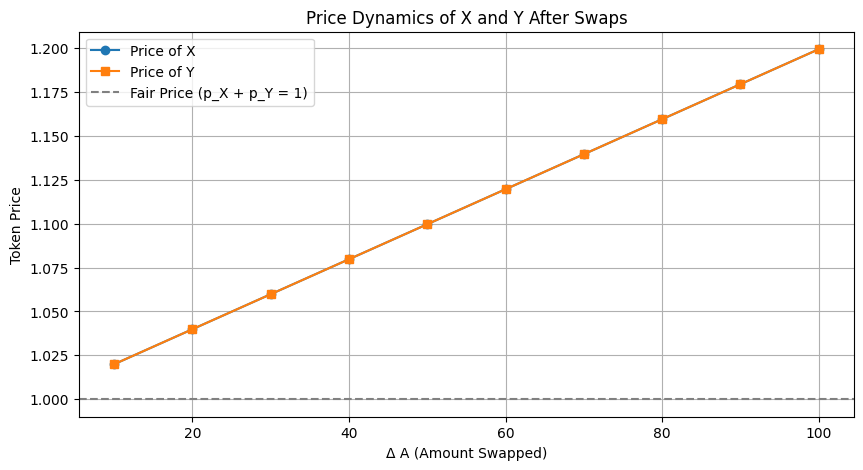

In [16]:
# 📌 Step 5: Visualize the Market Simulation Results

plt.figure(figsize=(10, 5))
plt.plot(df["Delta A"], df["New Price X"], label="Price of X", marker="o")
plt.plot(df["Delta A"], df["New Price Y"], label="Price of Y", marker="s")
plt.axhline(1, color='gray', linestyle='--', label="Fair Price (p_X + p_Y = 1)")
plt.xlabel("Δ A (Amount Swapped)")
plt.ylabel("Token Price")
plt.title("Price Dynamics of X and Y After Swaps")
plt.legend()
plt.grid()
plt.show()


In [44]:
def compute_k_piecewise(x, y):
    """
    Compute the price (liquidity factor) based on two reserves.
    When x == y, the price is 0.5.
      e.g. x=250, y=500 => 1 - 250/(2*500) = 0.75
           x=500, y=250 => 250/(2*500) = 0.25
    """
    if x <= 0 or y <= 0:
        raise ValueError("Both x and y must be positive.")
    if x <= y:
        return 1 - x / (2 * y)
    else:
        return y / (2 * x)

In [86]:
def dynamic_sell_fee(price, reference_price=0.5, base_fee=0.8, slope=0.9, min_fee=0.50):
    """
    Compute a dynamic sell fee multiplier based on the current price.

    Parameters:
      price          : current price (liquidity factor) from the split pool.
      reference_price: the price at which the fee is the base fee (default 0.5).
      base_fee       : fee multiplier at the reference price (default 0.95).
      slope          : determines how quickly the fee decreases for lower prices.
      min_fee        : a lower bound on the fee multiplier.

    Returns:
      A fee multiplier (between min_fee and base_fee). Lower price yields a lower multiplier,
      which means a higher fee is applied.
    """
    if price >= reference_price:
        return base_fee
    else:
        # For prices below the reference, subtract a fee adjustment proportional to the shortfall.
        fee = base_fee - slope * (reference_price - price)
        return max(fee, min_fee)

In [223]:
class TokenMarket:
    def __init__(self, initial_A, fee_buy=0.97, baseline_buy=480_000):
        """
        Initialize the market with a total amount of A tokens.

        • Half of the tokens remain as pure A (reserve_A).
        • The other half is split into X and Y (reserve_X and reserve_Y).
        In a balanced split pool the computed price (k) is 0.5.

        Additionally, a dynamic buy fee is used:
          - fee_buy: the maximum buy fee (when no income has been accumulated).
          - baseline_buy: the target income level at which the buy fee will drop to nearly 0.
          - income: accumulated income from sell operations.
        """
        self.fee_buy = fee_buy        # maximum buy fee (e.g., 0.97)
        self.baseline_buy = baseline_buy  # baseline income (e.g., 480,000)
        self.income = baseline_buy        # accumulated income from sell operations

        self.reserve_A = initial_A / 2.0
        self.reserve_X = initial_A / 2.0
        self.reserve_Y = initial_A / 2.0

    def get_dynamic_buy_fee(self):
        """
        Compute a dynamic buy fee that decreases as the accumulated income increases.

        When no income is accumulated, fee = self.fee_buy.
        When the accumulated income reaches or exceeds baseline_buy, fee becomes near 0.
        """
        fraction = min(self.income / self.baseline_buy, 0.9999)
        return self.fee_buy * (1 - fraction)

    def current_price(self):
        """Return the current price (liquidity factor) from the split pool."""
        return compute_k_piecewise(self.reserve_X, self.reserve_Y)

    def split_A(self, amount):
        """Convert pure A tokens into split tokens X and Y (1 A → 1 X + 1 Y)."""
        if self.reserve_A < amount:
            raise ValueError("Not enough pure A tokens to split.")
        self.reserve_A -= amount
        self.reserve_X += amount
        self.reserve_Y += amount
        print(f"Split {amount:.2f} A into {amount:.2f} X and {amount:.2f} Y.")

    def merge_XY(self, amount):
        """Merge split tokens X and Y into pure A tokens (1 X + 1 Y → 1 A)."""
        if self.reserve_X < amount or self.reserve_Y < amount:
            raise ValueError("Not enough tokens to merge.")
        self.reserve_X -= amount
        self.reserve_Y -= amount
        self.reserve_A += amount
        print(f"Merged {amount:.2f} X and {amount:.2f} Y into {amount:.2f} A.")

    # === SELL OPERATIONS ===
    def sell_A_for_X(self, amount_A):
        """
        Sell A tokens for X tokens.

        The ideal conversion is based on the current price from the split pool.
        In a balanced pool (price = 0.5), 15,000 A ideally yields 30,000 tokens.
        After applying a dynamic sell fee, the user might receive, for example, ~28,500 tokens.
        If the split pool lacks sufficient X tokens, the operation falls back to the buy mechanism.
        """
        price = self.current_price()
        fee_sell = dynamic_sell_fee(price)
        ideal_X = amount_A / price
        out_X = ideal_X * fee_sell

        if out_X > self.reserve_X:
            print("Insufficient X liquidity in split pool; switching to buy mode.")
            return self.buy_A_for_X(amount_A)

        self.reserve_A += amount_A
        self.reserve_X -= out_X

        # Update accumulated income (here we simply add the A tokens received)
        self.income += amount_A * 0.05

        print(f"Sell (for X): Received {amount_A:.2f} A → delivered {out_X:.2f} X "
              f"(price: {price:.4f}, fee: {fee_sell:.4f}).")
        return out_X

    def sell_A_for_Y(self, amount_A):
        """
        Sell A tokens for Y tokens.

        This is symmetric to sell_A_for_X but uses the reversed reserves
        to compute the effective price.
        """
        price_Y = compute_k_piecewise(self.reserve_Y, self.reserve_X)
        fee_sell = dynamic_sell_fee(price_Y)
        ideal_Y = amount_A / price_Y
        out_Y = ideal_Y * fee_sell

        if out_Y > self.reserve_Y:
            print("Insufficient Y liquidity in split pool; switching to buy mode.")
            return self.buy_A_for_Y(amount_A)

        self.reserve_A += amount_A
        self.reserve_Y -= out_Y
        self.income += amount_A * 0.05

        print(f"Sell (for Y): Received {amount_A:.2f} A → delivered {out_Y:.2f} Y "
              f"(price: {price_Y:.4f}, fee: {fee_sell:.4f}).")
        return out_Y

    # === BUY OPERATIONS ===
    def buy_A_for_X(self, amount_A):
        """
        Buy operation for X:

        When the split pool liquidity is insufficient, we use a Uniswap V2–style mechanism.
        The user supplies amount_A tokens, and the pool “sacrifices” an extra amount A_out from
        its pure A reserve. The dynamic buy fee (which decreases as accumulated income increases)
        is used in the calculation.

        The user receives (amount_A + A_out) tokens in X, and the pool’s pure A reserve is reduced by A_out.
        """
        R_A = self.reserve_A
        dynamic_fee = self.get_dynamic_buy_fee()
        const_k = R_A * amount_A
        A_out = R_A - const_k / (amount_A + amount_A * dynamic_fee)

        self.reserve_A -= A_out
        # To maintain the invariant, update the opposite side (Y) of the split pool.
        self.reserve_Y += amount_A + A_out

        out_X = amount_A + A_out
        print(f"Buy (for X): Provided {amount_A:.2f} A, pool supplies extra {A_out:.2f} A; "
              f"user receives {out_X:.2f} X (dynamic fee: {dynamic_fee:.4f}).")
        return out_X

    def buy_A_for_Y(self, amount_A):
        """
        Buy operation for Y:

        Analogous to buy_A_for_X: the user supplies amount_A tokens, the pool calculates A_out using
        the dynamic fee, and the user receives (amount_A + A_out) tokens in Y.
        """
        R_A = self.reserve_A
        dynamic_fee = self.get_dynamic_buy_fee()
        const_k = R_A * amount_A
        A_out = R_A - const_k / (amount_A + amount_A * dynamic_fee)

        self.reserve_A -= A_out
        # Update the opposite side (X) of the split pool.
        self.reserve_X += amount_A + A_out

        out_Y = amount_A + A_out
        print(f"Buy (for Y): Provided {amount_A:.2f} A, pool supplies extra {A_out:.2f} A; "
              f"user receives {out_Y:.2f} Y (dynamic fee: {dynamic_fee:.4f}).")
        return out_Y

    def log_state(self):
        """Print the current reserves, price, and accumulated income."""
        print("=== Market State ===")
        print(f"Pure A reserve:    {self.reserve_A:.2f}")
        print(f"Split pool:  X = {self.reserve_X:.2f}    Y = {self.reserve_Y:.2f}")
        print(f"Current price (k): {self.current_price():.4f}")
        print(f"Accumulated income: {self.income - self.baseline_buy:.2f} (Baseline: {self.income})")
        total_A_amount = self.reserve_A + min(self.reserve_X, self.reserve_Y)

        x_wins = self.reserve_A + self.reserve_X
        y_wins = self.reserve_A + self.reserve_Y

        print(f"If    X   wins: {x_wins:.4f}")
        print(f"If    Y   wins: {y_wins:.4f}")
        print(f"Total A amount: {total_A_amount:.4f}")
        print("====================\n")

In [224]:
market = TokenMarket(initial_A=500_000, fee_buy=0.97, baseline_buy=480_000)
market.log_state()

=== Market State ===
Pure A reserve:    250000.00
Split pool:  X = 250000.00    Y = 250000.00
Current price (k): 0.5000
Accumulated income: 0.00 (Baseline: 480000)
If    X   wins: 500000.0000
If    Y   wins: 500000.0000
Total A amount: 500000.0000



In [225]:
print("\n--- User sells 15,000 A for X ---")
out1 = market.sell_A_for_X(15_000)
market.log_state()


--- User sells 15,000 A for X ---
Sell (for X): Received 15000.00 A → delivered 24000.00 X (price: 0.5000, fee: 0.8000).
=== Market State ===
Pure A reserve:    265000.00
Split pool:  X = 226000.00    Y = 250000.00
Current price (k): 0.5480
Accumulated income: 750.00 (Baseline: 480750.0)
If    X   wins: 491000.0000
If    Y   wins: 515000.0000
Total A amount: 491000.0000



In [252]:
print("\n--- User sells another 15,000 A for X ---")
out2 = market.sell_A_for_X(15_000)
market.log_state()


--- User sells another 15,000 A for X ---
Insufficient X liquidity in split pool; switching to buy mode.
Buy (for X): Provided 15000.00 A, pool supplies extra 46.02 A; user receives 15046.02 X (dynamic fee: 0.0001).
=== Market State ===
Pure A reserve:    474401.43
Split pool:  X = 3278.17    Y = 445598.57
Current price (k): 0.9963
Accumulated income: 11250.00 (Baseline: 491250.0)
If    X   wins: 477679.5980
If    Y   wins: 920000.0000
Total A amount: 477679.5980



In [253]:
print("\n--- User sells 600,000 A for X (triggering buy mode) ---")
out3 = market.sell_A_for_X(600_000)
market.log_state()


--- User sells 600,000 A for X (triggering buy mode) ---
Insufficient X liquidity in split pool; switching to buy mode.
Buy (for X): Provided 600000.00 A, pool supplies extra 46.01 A; user receives 600046.01 X (dynamic fee: 0.0001).
=== Market State ===
Pure A reserve:    474355.42
Split pool:  X = 3278.17    Y = 1045644.58
Current price (k): 0.9984
Accumulated income: 11250.00 (Baseline: 491250.0)
If    X   wins: 477633.5855
If    Y   wins: 1520000.0000
Total A amount: 477633.5855



In [269]:
print("\n--- User sells 15,000 A for Y ---")
market.sell_A_for_Y(150_000)
market.log_state()


--- User sells 15,000 A for Y ---
Insufficient Y liquidity in split pool; switching to buy mode.
Buy (for Y): Provided 150000.00 A, pool supplies extra 60.48 A; user receives 150060.48 Y (dynamic fee: 0.0001).
=== Market State ===
Pure A reserve:    623462.22
Split pool:  X = 2254171.37    Y = 22670.30
Current price (k): 0.0050
Accumulated income: 18750.00 (Baseline: 498750.0)
If    X   wins: 2877633.5855
If    Y   wins: 646132.5155
Total A amount: 646132.5155



In [274]:
print("\n--- User sells 15,000 A for Y ---")
market.sell_A_for_X(150_000)
market.log_state()


--- User sells 15,000 A for Y ---
Insufficient X liquidity in split pool; switching to buy mode.
Buy (for X): Provided 150000.00 A, pool supplies extra 89.55 A; user receives 150089.55 X (dynamic fee: 0.0001).
=== Market State ===
Pure A reserve:    923237.18
Split pool:  X = 74635.54    Y = 472895.34
Current price (k): 0.9211
Accumulated income: 33750.00 (Baseline: 513750.0)
If    X   wins: 997872.7187
If    Y   wins: 1396132.5155
Total A amount: 997872.7187

